# Exploratory Data Analysis on the Chess Dataset

In this notebook we continue from the data wrangling notebook, where our goal is to analyze and discover what features influence victory in chess. In this notebook the focus is on exploring each feature to see which ones will ultimately be used for training. Some test used here were guided by the information in the link: https://towardsdatascience.com/6-types-of-feature-importance-any-data-scientist-should-master-1bfd566f21c9.

## Getting Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [3]:
#cleaned dataframe was saved as a pickle file in the data wrangling notebook
df = pd.read_pickle(r'chess_data')
df.head()

,id,rated,turns,victory_status,winner,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,time_allotted,increment,total_time
0,TZJHLljE,False,13,outoftime,white,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,15,2,0.0
1,l1NXvwaE,True,16,resign,black,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,5,10,0.0
2,mIICvQHh,True,61,mate,white,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,5,10,0.0
3,MsoDV9wj,False,5,draw,draw,trelynn17,1250,franklin14532,1002,e4 c5 Nf3 Qa5 a3,B27,Sicilian Defense: Mongoose Variation,4,10,0,0.0
4,qwU9rasv,True,33,resign,white,capa_jr,1520,daniel_likes_chess,1423,d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,10,10,0,0.0


In [4]:
#recalling some stats from the previous notebook
df.describe()

,turns,white_rating,black_rating,opening_ply,time_allotted,increment,total_time
count,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000
mean,60.513839,1597.300005,1590.045519,4.815780,13.785277,5.146497,872.610863
std,33.488264,290.022740,290.441694,2.798283,17.072447,13.808620,4909.234562
min,1.000000,784.000000,789.000000,1.000000,0.000000,0.000000,0.000000
25%,37.000000,1401.000000,1394.000000,3.000000,10.000000,0.000000,0.000000
50%,55.000000,1567.000000,1563.000000,4.000000,10.000000,0.000000,251.850000
75%,79.000000,1792.000000,1785.000000,6.000000,15.000000,7.000000,798.865000
max,349.000000,2700.000000,2723.000000,28.000000,180.000000,180.000000,605844.701000


## Beginning EDA

From the context of this problem (and the previous notebook), we already know the dependent variable that we will be predicting is the `winner` feature. Also, id features usually don't make much sense in predicting features, so there is no point in exploring the `id`, `white_id`, and the `black_id` features. This leaves us with the following independent features to explore: `rated`, `turns`, `victory_status`, `white_rating`, `black_rating`, `moves`, `opening_eco`, `opening_name`, `opening_ply`, `time_allotted`, `increment`, `total_time`. We will tackle each one indiviudally.

Let's start off with correlations and a pairplot to get a general sense of some relations.

In [5]:
df.corr()

,rated,turns,white_rating,black_rating,opening_ply,time_allotted,increment,total_time
rated,1.000000,0.088763,0.002397,0.027282,-0.008122,-0.105925,-0.100459,-0.029094
turns,0.088763,1.000000,0.131335,0.159903,0.054168,-0.057939,-0.059956,0.058639
white_rating,0.002397,0.131335,1.000000,0.636569,0.278861,-0.069447,-0.019090,0.009097
black_rating,0.027282,0.159903,0.636569,1.000000,0.256081,-0.079036,-0.027937,0.007006
opening_ply,-0.008122,0.054168,0.278861,0.256081,1.000000,-0.031575,-0.009705,0.007549
time_allotted,-0.105925,-0.057939,-0.069447,-0.079036,-0.031575,1.000000,0.458047,0.105951
increment,-0.100459,-0.059956,-0.019090,-0.027937,-0.009705,0.458047,1.000000,0.126617
total_time,-0.029094,0.058639,0.009097,0.007006,0.007549,0.105951,0.126617,1.000000


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


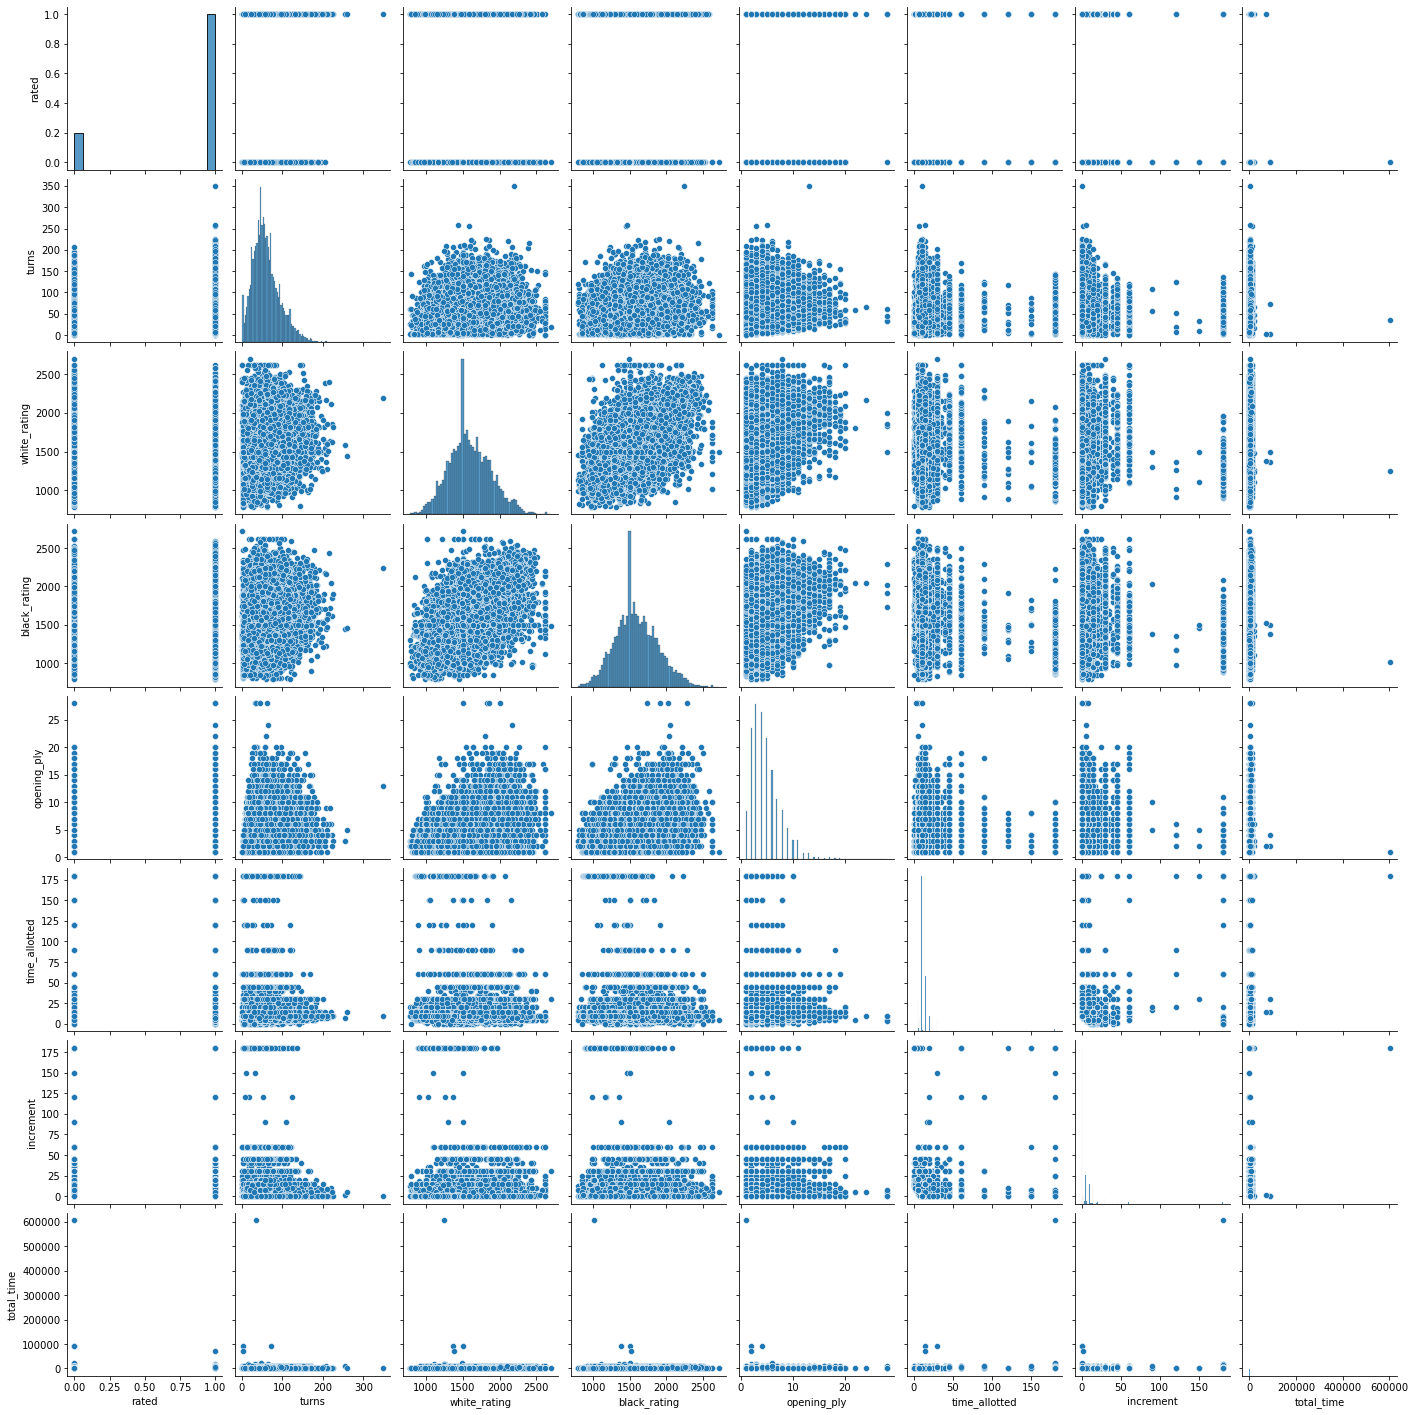

In [6]:
sns.pairplot(df)

Unfortunately, there isn't really anything useful here. The only exception is that the `black_rating` and `white_rating` features seem to be somewhat positively correlated, indicating that they may be redundent independent vectors. Intuitively, you would think they would both be relevant though, and a 0.64 correlation value does suggest that these are not correlated enough to be redundant. We should make sure though, later on.

Also, note that a lot of important features aren't in this pairplot, including the `winner` feature, since they are not numeric features.

## Univariate Analysis

### Rated 

Starting off with the `rated` features, let's see if we should use it for our predictions later on. The following is a histogram displaying the difference in number of victorys for rated and unrated games.

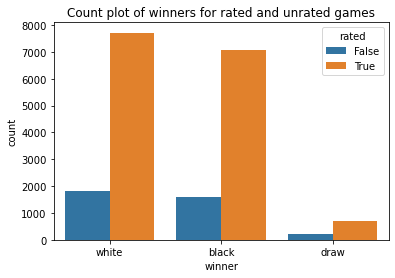

In [6]:
sns.countplot(data=df, x='winner', hue='rated')
plt.title('Count plot of winners for rated and unrated games')
plt.show()

Since the ratio of rated to unrated games is similar for both players of black and white, in terms of victory, it seems like this feature may not be a useful feature help predict the winner. In fact, this graph really just shows that there are significantly more rated games than unrated games, and that if you find out a game is rated, then it has roughly an equal chance of having a black or white winner. 

Let's confirm the ratio's anyway's, to make sure.

In [7]:
black_winners = df[df['winner'] == 'black']
black_winners['rated'].value_counts()

True     7072
False    1608
Name: rated, dtype: int64

In [8]:
white_winners = df[df['winner'] == 'white']
white_winners['rated'].value_counts()

True     7711
False    1834
Name: rated, dtype: int64

So the ratio of rated vs unrated games where the player who chose black won is about 4.4. In contrast, the ratio of rated vs unrated games where the player who chose white won is about 4.2. If we were to predict what would make a player who chose either black or white win individually, then I would expect this feature would positively affect model prediction, but only a little bit. 

Let's try a quick Chi-Squre test statistic to get the p-value and see this features importance. The Chi-Square is meant for seeing how important a categorical feature is in predicting another categorical feature, which is the case here, and hence why we use this test. For more information, see the following link: https://towardsdatascience.com/using-the-chi-squared-test-for-feature-selection-with-implementation-b15a4dad93f1.

In [9]:
# quick statistical test to get the p value
X = df[['rated']]
y = df[['winner']]

print('The p_value for an F statistic with the rated feature:', chi2(X, y.values.ravel())[1][0])

The p_value for an F statistic with the rated feature: 0.3652723377682627


So here the null hypothesis would be that there is no statistical significance between these two features, and given this p value, it seems like this is true. Thus, we need not consider this feature when modelling later on.

### Turns 

The next feature to look at is the `turns` feature.

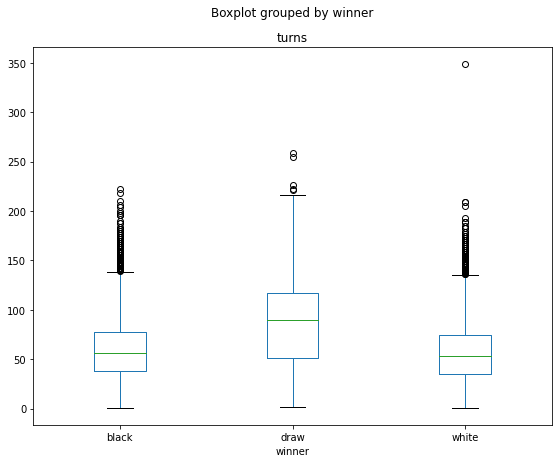

In [59]:
#enlarge figsize
plt.rcParams["figure.figsize"] = (9, 7)

df.boxplot(by = 'winner', column = ['turns'], grid=False)
plt.show()

This plot just shows the range of values of the turns feature. For each winner category the range of values is roughly the same, with the exception being if the game was a draw. This means that the number of turns doesn't really influence the winner, but that games that run a bit longer than normal may favour a draw. Thus, it seems like games with lower turn counts are less likely to have a winner, which is somewhat useful in predicting a winner. So let's now try a simple logistic regression model with just the `turns` feature, to see how well it can predict the `winner` feature.

In [40]:
#logistic regression function for quick testing of a feature
#logistic regression is a classification model, so it will do well here
def log_reg(X, y, ):
    x_train, x_test, y_train, y_test = train_test_split(X, y)
    
    log_reg = linear_model.LogisticRegression(random_state=40)
    
    log_reg.fit(x_train, y_train.values.ravel())
    
    #log reg score
    score = log_reg.score(x_train, y_train.values.ravel())
    
    #getting the predicted values from the test set, for the confusion matrix
    y_pred = log_reg.predict(x_test)
    
    #we will also plto the confusion matrix
    con_mat = confusion_matrix(y_test.values.ravel(), y_pred, labels=["white", "black", "draw"])
    
    return score, con_mat

In [12]:
#getting our X and y variable and making training and testing sets
X = df[['turns']]
y = df[['winner']]

#using the log_reg function to quickly get a score and confusion matrix
score, con_mat = log_reg(X, y)

print('The logistic regression score for the turns feature is:', score)

The logistic regression score for the turns feature is: 0.5016045765313242


A score of 0.5 is okay, but you could almost predict just white or black winners and get the same score, so maybe the confusion matrix will give some more insight.

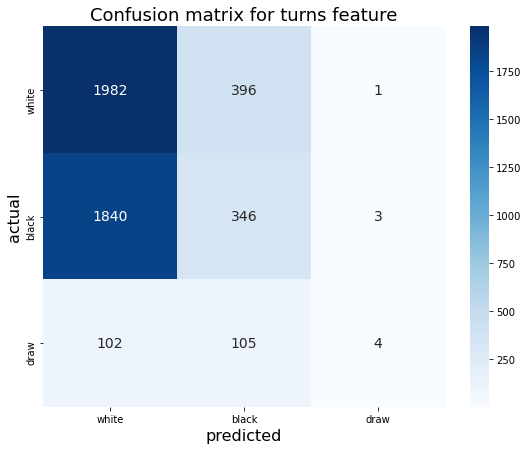

In [13]:
#make the confusion matrix more readable with a heatmap
sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["white", "black", "draw"], yticklabels = ["white", "black", "draw"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for turns feature', fontsize=18)
plt.show()

So above you can see the 0.5 score in action. To see it, look at just one predicted value, like the white column, and you'll notice that about half of the predicted rows were correct. Similary, for the other two predicted columns about half of the predictions are correct. For some reason, this feature favours predicting white as the winner, when the boxplot suggested it would favour white and black equally. This is almost like having a model that only predicts white as the winner, as mentioned above, but still it is a little better than that.

Let's try a statistical test before deciding on what to do. The F test works for both classification and regression, with continuous independent variables, so we can use the classification version her thanks to sklearn.

In [14]:
print('The p_value for an F statistic with the turns feature:', f_classif(X, y.values.ravel())[1][0])

The p_value for an F statistic with the turns feature: 5.04241048991454e-139


So it seems, with a p value of essentially 0, this feature may be important afterall. Thus, we now know more about this feature, like that it has similar range of values for white and black winners, and longer games tend to end in draws. Also from the box plot, there are more than a few outliers, so the games that don't end in a draw stillcan run a bit longer that normal. Finally, with the p value, it seems like this feature is worth including in predictive modelling later on.

### Victory Status

The `victory_status` feature is a categorical feature, just like the rated feature, but this time it is not binary. We can again look at a count plot to start off.

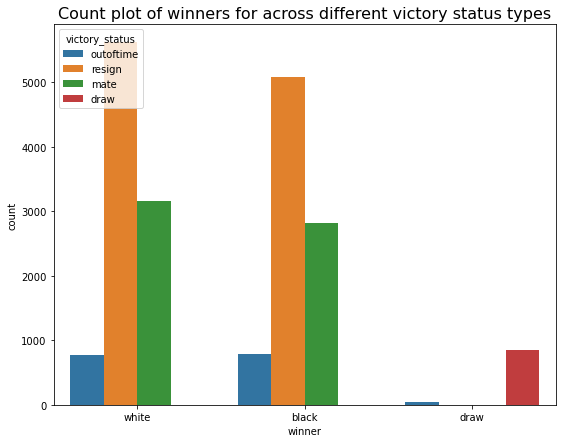

In [15]:
sns.countplot(data=df, x='winner', hue='victory_status')
plt.title('Count plot of winners for across different victory status types', fontsize=16)
plt.show()

Interestingly, the distributions here are very similar for both white and black winners, so again intuitively one might expect this feature to be useless. Although, at the same time, intuition might suggest that having this feature tell you that simply having a winner would be useful. In any case, let's try a regression model.

(You can also see there are no counts for draw for white or black winners, which of course wouldn't make any sense. But it almost feels like that makes for some redundant information here, and perhaps games that ended in a draw may be useless games for predictions in the end.)

In [16]:
X = df[['victory_status']]
y = df[['winner']]

#as a categorical independent variable, we need to one-hot-encode this feature to input it into out logistic regression
X = pd.get_dummies(X)

score, con_mat = log_reg(X, y)

print('The logistic regression score for the turns feature is:', score)

The logistic regression score for the turns feature is: 0.5439514441188782


A score of 0.55 with simply logistic regression isn't too bad. Let's get a better look at this score with the confusion matrix.

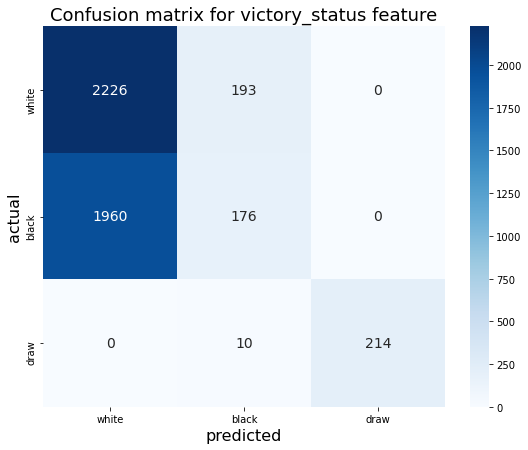

In [17]:
sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["white", "black", "draw"], yticklabels = ["white", "black", "draw"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for victory_status feature', fontsize=18)
plt.show()

So again we can see for each predicted variables in the columns of this confusion matrix, about half of them are correct, which is in line with the score above. The exception is the draw category, but this makes sense from the histogram above, and again, of course it doesn't make sense for white or black to if they draw. 

Tis matrix is quite like the last one, in that it favours white to be the winner. Let's try a statistical test to make sure it is a good feature with the p value. 

In [18]:
print('p values for the victory_status feature:', chi2(X, y.values.ravel())[1])

p values for the victory_status feature: [0.00000000e+000 4.30805024e-064 3.15345972e-005 6.64053559e-114]


We one-hot encoded the `victory_status` feature, which is why we got four p values, but they are all essentially zero, so it looks like again this feature is of importance (since the null hypothesis would have been that there is no significance between it and the `winner` feature).

Thus, this feature should be used for model prediction later on. The data we use for it in the end will have to have the dummy variables we used here though, but this can be done later after all the other features have been explored.

### White and Black Rating

These two rating features we will look at at the same time here, because they may be correlated and thus redundant, as pointed out earlier in the notebook. Let's plot them again here, and recall the correlation was 0.64.

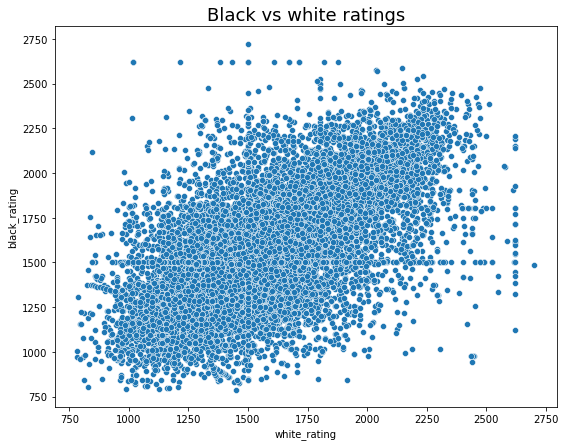

In [19]:
sns.scatterplot(x='white_rating', y='black_rating', data=df)
plt.title('Black vs white ratings', fontsize=18)
plt.show()

So with this larger plot, the positive correlation is much clearer. Now let's see how these two features impact the `winner` target feature individually.

In [20]:
X_w = df[['white_rating']]
X_b = df[['black_rating']]
y = df[['winner']]

score_w, con_mat_w = log_reg(X_w, y)
score_b, con_mat_b = log_reg(X_b, y)

print('The logistic regression score for the white ratings feature is:', score_w)
print('The logistic regression score for the black ratings feature is:', score_b)

The logistic regression score for the white ratings feature is: 0.4986047160597182
The logistic regression score for the black ratings feature is: 0.49679084693735176


So both of these features have a score of about 0.5, with a slight edge to the `black_rating` feature. Thus, from exploring previous features it is fair to assume that both of these features are probably important. Let's now get a confusion matrix for them as we did before.

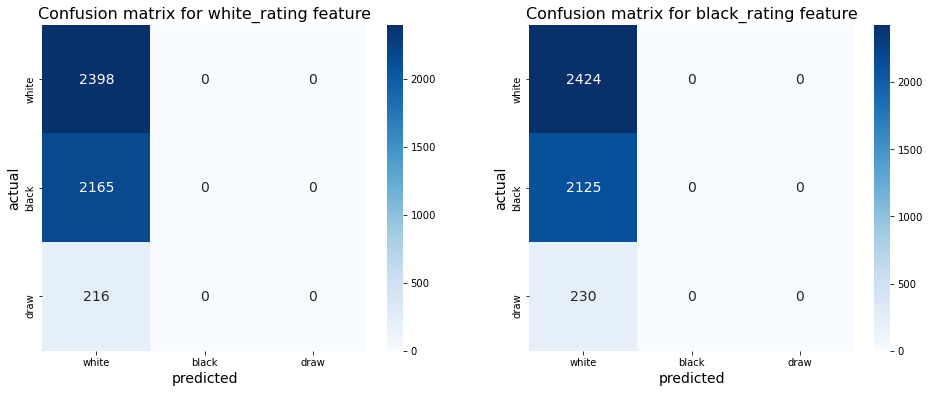

In [21]:
#making subplots here for easy visuals and comparison
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

sns.heatmap(con_mat_w, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14}, ax = ax1,
            xticklabels = ["white", "black", "draw"], yticklabels = ["white", "black", "draw"])
sns.heatmap(con_mat_b, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14}, ax = ax2,
            xticklabels = ["white", "black", "draw"], yticklabels = ["white", "black", "draw"])

ax1.set_xlabel('predicted', fontsize = 14)
ax1.set_ylabel('actual', fontsize = 14)
ax1.set_title('Confusion matrix for white_rating feature', fontsize = 16)

ax2.set_xlabel('predicted', fontsize = 14)
ax2.set_ylabel('actual', fontsize = 14)
ax2.set_title('Confusion matrix for black_rating feature', fontsize = 16)

plt.show()

These confusion matrices show their respective scores just like the previous feature's confusion matrices, but for some reason with the confusion matrix for the `white_rating` feature, the only predicted category was white. This seems strange, but if you look at all other confusion matrices, you'll see they all favour predicting white as well, just not as extreme as only predicting white. The only matrix that seems more balanced in this regard would be the one above for the `black_rating` feature. It still favours white, but not as much as previous matrices. This could be the first indication that simply choosing to play as white favours victory.

Also, as far as feature importance goes, the `white_rating` features is now seemingly just as good as a model that only predicts white. This in general is not good, so this whole feature might not be worth keeping (and maybe could bias the model to favour predicting white). 

These are just some observations to note. That being said, with the logistic regression score of about 0.5, it would still stand to keep the `white_rating` feature. Let's use the F test to see their statistical significance.

In [53]:
print('The p value for the white rating is:', f_classif(X_w, y.values.ravel())[1][0])
print('The p value for the white rating is:', f_classif(X_b, y.values.ravel())[1][0])

The p value for the white rating is: 7.710099600439561e-91
The p value for the white rating is: 2.5106721360727276e-123


Well, it seem that both of these features are important, so we should use them for modelling later on. Although, earlier it seemed like these features may be redundant, so if we find this is the case, then it would make sense to drop the `white_rating` feature over the `black_rating` feature, given what we've seen so far. Let's now see if they are redundant features with hypothesis testing. **The null hypothesis here is that there is no strong relationship between the `white_rating` feature and the `black_rating` feature (or rather not strong enough/statistically significant).**

In [8]:
white = df[['white_rating']]
black = df[['black_rating']]

In [55]:
# quick check to see if these are normally distributed
print('Normal test for white_rating:', stats.normaltest(white))
print('Normal test for black_rating:', stats.normaltest(black))

Normal test for white_rating: NormaltestResult(statistic=array([259.46759033]), pvalue=array([4.54285259e-57]))
Normal test for black_rating: NormaltestResult(statistic=array([195.67090683]), pvalue=array([3.24042853e-43]))


Since both of these p values are essentially zero, we can say that they are not normally distributed from this alone. But we can plot the normal distribution to be sure.

C:\Users\RaviB\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


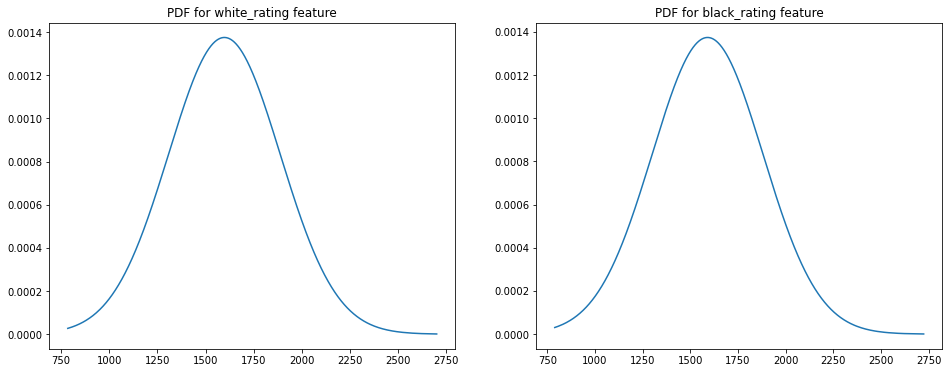

In [35]:
#getting the means and std's
m_w = np.mean(white)[0]
s_w = np.std(white)[0]

m_b = np.mean(black)[0]
s_b = np.std(black)[0]

#normal distributions for each feature
pdf_w = stats.norm.pdf(white.sort_values(by='white_rating'), loc=m_w, scale=s_w)
pdf_b = stats.norm.pdf(black.sort_values(by='black_rating'), loc=m_b, scale=s_b)

#plotting them both at the same time

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

ax1.plot(white.sort_values(by='white_rating')['white_rating'], pdf_w)
ax1.set_title('PDF for white_rating feature')

ax2.plot(black.sort_values(by='black_rating')['black_rating'], pdf_b)
ax2.set_title('PDF for black_rating feature')

plt.show()

So both of these features are indeed normally distributed. The sample size here is probably too large for that normal/p test to be useful. In any case, both of these distributions look very similar, so they are probably not independent from each other, but finishing the hypothesis test now will confirm this.

Since these features are normally distributed, and we want to test if they are significantly different from each other, a F test would be a good choice here. Some information on how to do this was gathered from the following link: https://stackoverflow.com/questions/21494141/how-do-i-do-a-f-test-in-python. There is a slight error in the calculation of the p-value in this link though, so this other link has the correction: https://www.geeksforgeeks.org/how-to-perform-an-f-test-in-python/.

In [ ]:
var_w = np.var(white)[0]
var_b = np.var(black)[0]
print('The white_rating feature variance is:', var_w, 'and the black_rating feature variance is:', var_b)

In [ ]:
#since the black_rating feature is greater, it goes on the numerator for calculating the F value
F = var_b / var_w
F

In [ ]:
p_value_f = 1 - stats.f.cdf(F, black.shape[0]-1, white.shape[0]-1)
p_value_f

So you can see that from the F value, these two features share a similar variance. But, the p_value_f is quite large, so even with the typical alpha value of 0.05, it is nor less than that. Thus, the null hypothesis test should not be rejected. This means that the relationship between these two ratings features is not strong enough to have one of them be redundant. This was initially the prediction at the beginning of this notebook, based on intuition, and it looks like intuition was right here. Thus, we will not drop either of these features for model prediction.

Before moving on, the first link mentioned just above suggested two other statistical tests that might be more robust. Thanks to scipy, it is easy to try these, so we can do them quickly now for another confirmation that the null hypothesis cannot be rejected.

In [ ]:
F_bart, p_bart = stats.bartlett(np.array(white).ravel(), np.array(black).ravel())
F_lev, p_lev = stats.levene(np.array(white).ravel(), np.array(black).ravel())

print('The p value for the Bartlett Test is:', p_bart)
print('The p value for the Levene Test is:', p_lev)

Again, these p values are too large for any statistical significance, so we will keep both of these features and move on.

## Time Features

Let's tackle the time-related features next. These are the `time_allotted` (unit is minutes), `increment` (unit is seconds), and `total_time` (unit is seconds) features.

### Total Time

Something noted in the previous notebook was that there is a lot of rows/games where the `total_time` = 0. This doesn't make any sense, and below you can see there are almost half of the games with this situation. We already have time-related information in the other two features, and you could even simulate a value similar to the total time of a game by multiplying the increment by the number of turns, and then adding that to the time allotted. This would give the maximum time that the players had for their game though, not the total time of the game. If need be we could use this feature, but that information already lies with the `time_allotted` and `increment` features, so it would be redundant. It might however be a way to combine these features into one, as a feature reduction tactic, but intuition would say there is valuable information in these features seperately, so this should be left for later exploration if need be. 

Let's now do some basic exploration to ensure removing this feature is the right move.

In [36]:
df[df['total_time'] == 0].shape

(8058, 16)

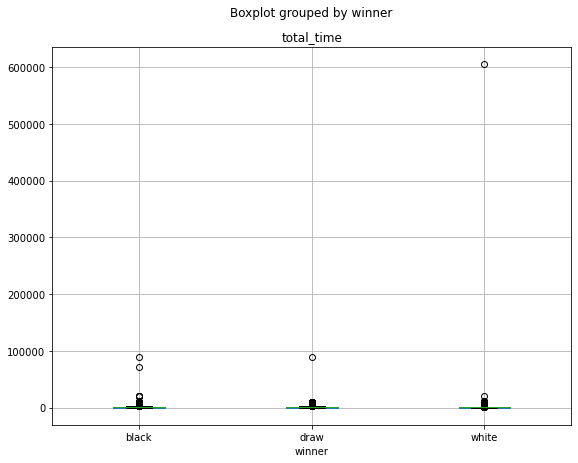

In [60]:
df[['total_time', 'winner']].boxplot(by = 'winner', column = ['total_time'])
plt.show()

This box plot shows how skewed the data is towards zero, since almost half of the values are zero. The few outliers do make this unreadable though, so let's zoom in a bit.

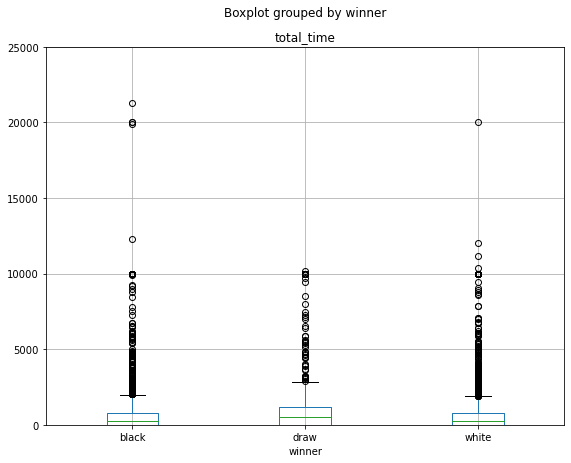

In [61]:
df[['total_time', 'winner']].boxplot(by = 'winner', column = ['total_time'])
plt.ylim([0, 25000])
plt.show()

So you can now see that all these zero values drag the box to the bottom, and have all other useful values as outliers. Regardless, we can do a quick logistic regression analysis check before deciding to drop the column.

In [62]:
X = df[['total_time']]
y = df[['winner']]

score, con_mat = log_reg(X, y)

print('The logistic regression score for the total_time feature is:', score)

The logistic regression score for the total_time feature is: 0.500767406167155


Well, with a score of 0.5, which has been our cut off thus far, it would be unfair to remove this feature based off this, so let's look at the confusion matrix. 

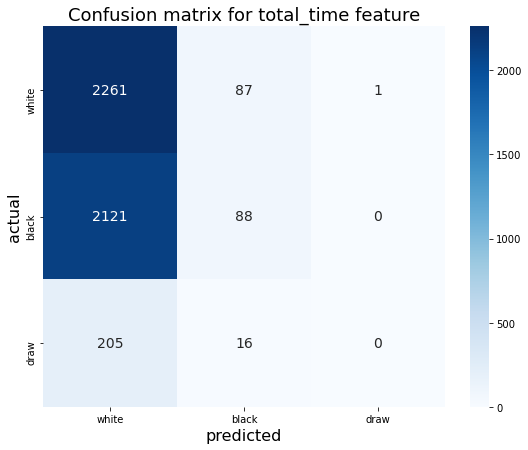

In [63]:
sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["white", "black", "draw"], yticklabels = ["white", "black", "draw"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for total_time feature', fontsize=18)
plt.show()

Looks like this model is only predicting white. Thus this feature is probably not worth keeping if it is only going to be a 'predict only white' model. Let's do an F statistic before moving on. 

In [64]:
print('The p value for the total_time feature is:', f_classif(X, y.values.ravel())[1][0])

The p value for the total_time feature is: 0.012553389921719836


So this p value is less than the typical 0.05, but it is still small. I would argue that since all the p values in previous features were significantly smaller than this, this p value indicates that the null hypothesis should not be rejected, and that the `total_time` feature is not significant enough, and thus should not be used for predictive modelling later on.

But if we get a 50% score with so many rows that are 0, would the model be better if we tried it without these rows?

In [65]:
tt_mod_df = df[df['total_time'] != 0]

In [66]:
X = tt_mod_df[['total_time']]
y = tt_mod_df[['winner']]

score, con_mat = log_reg(X, y)

print('The logistic regression score for the total_time feature with no 0 values is:', score)

The logistic regression score for the total_time feature with no 0 values is: 0.5003015317814498


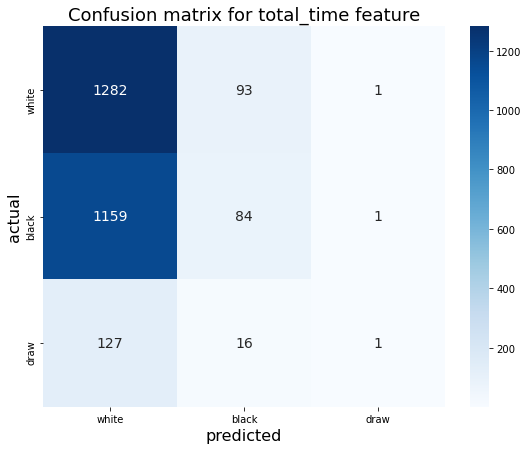

In [67]:
sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["white", "black", "draw"], yticklabels = ["white", "black", "draw"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for total_time feature', fontsize=18)
plt.show()

In [68]:
print('The p value for the total_time feature is:', f_classif(X, y.values.ravel())[1][0])

The p value for the total_time feature is: 0.042465615026254566


Seems like this did help a bit, making it not only predict white. It is odd that so many features are getting a score of 50%, since almost half the time white wins and the other half black wins (ignoring draws for now since they are a small subset). Still, combining a significant p value with a confusion matrix that shows that not only white is being predicted should be enough to suggest that the feature has value for predictive modelling.

That being said, since the p value here is large, but the model is not doing as bad now, it seems inconclusive to say there is not statistical significance here. Unfortunately, to get this results too many rows were removed from the original dataset. This means in order for this feature to be of use, we would have to remove all these rows, which may not be a good idea. Thus, it seems the case of the `total_time` feature is a special case, and might need to be considered seperately later on when getting the final model.

### Time Allotted

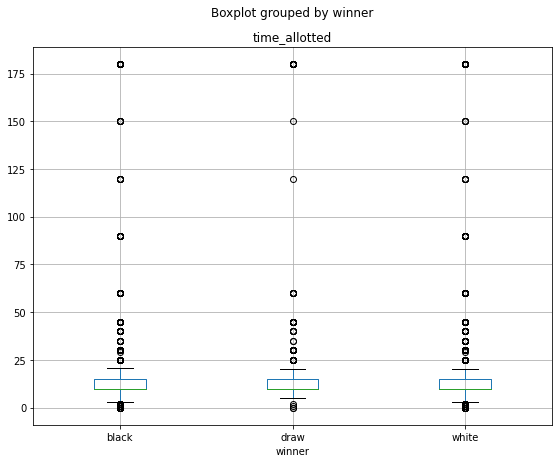

In [69]:
df.boxplot(by = 'winner', column = ['time_allotted'])
plt.show()

In [70]:
print('Most frequent value for time allotted:', max(df[['time_allotted']].value_counts()))

Most frequent value for time allotted: 8987


You can see that the time allotted for games tends to be the same for most games, which is 10 minutes. Still, there are a lot of other values. Let's look at a regression model now.

In [71]:
X = df[['time_allotted']]
y = df[['winner']]

score, con_mat = log_reg(X, y)

print('The logistic regression score for the time_allotted feature is:', score)

The logistic regression score for the time_allotted feature is: 0.5013952839402819


A score of 0.5 as with all other features is okay. Let's look at the confusion matrix to see if it only predicts white.

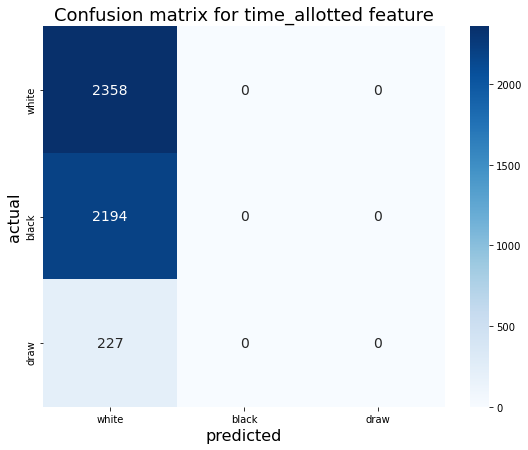

In [72]:
sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["white", "black", "draw"], yticklabels = ["white", "black", "draw"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for time_allotted feature', fontsize=18)
plt.show()

In [73]:
print('The p value for the time allotted feature is:', f_classif(X, y.values.ravel())[1][0])

The p value for the time allotted feature is: 2.0795943191994896e-06


So the confusion matrix predicts only white, which is not good. The p value is not nearly as small as the other p values that had statistically significant features, but it is still significantly smaller than 0.05. I would argue that this is inconclusive, although it might be the case that the only importance this feature has is to inform whether or not a game will have a victor due to a time loss. But the `victory_status` feature already has this information, which we deemed as important earlier. Thus, perhaps it if fine to no longer consider this feature.

### Increment 

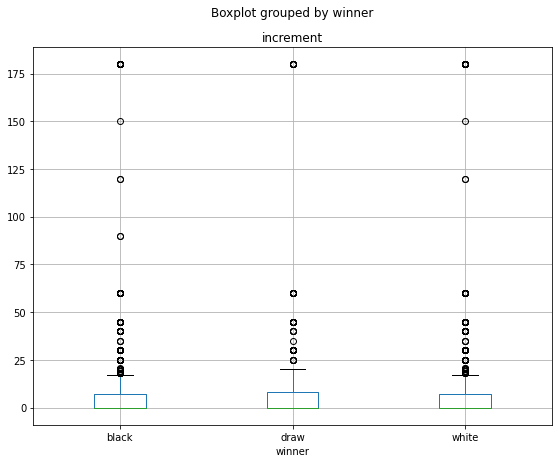

In [74]:
df.boxplot(by = 'winner', column = ['increment'])
plt.show()

This feature suffers the same problem as the `total_time` feature, with too many 0 or low values dragging the mean to the bottom of the boxplot. The difference here is that `increment` values of 0 makes sense, as some games just have a `time_allotted` value with no additional time given per turn. Let's continue with logistic regression anyways.

In [75]:
X = df[['increment']]
y = df[['winner']]

score, con_mat = log_reg(X, y)

print('The logistic regression score for the increment feature is:', score)

The logistic regression score for the increment feature is: 0.4959536765731826


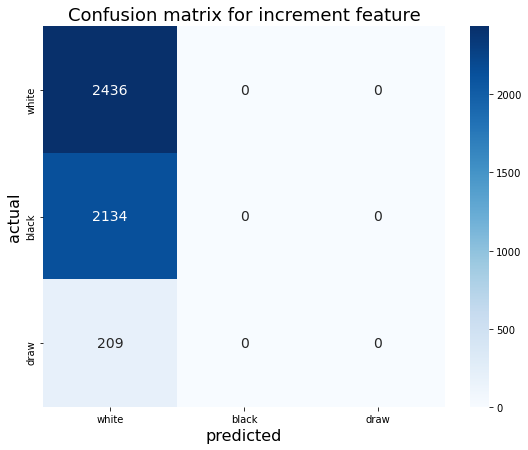

In [76]:
sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["white", "black", "draw"], yticklabels = ["white", "black", "draw"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for increment feature', fontsize=18)
plt.show()

In [77]:
print('The p value for the increment feature is:', f_classif(X, y.values.ravel())[1][0])

The p value for the increment feature is: 1.3943682442938926e-05


Alas, this feature has the same issue as the `time_allotted` feature, and thus it is somewhat unclear if this feature is statistically significant. Although, if we reason that the `victory_status` feature already has the information that we would gain from this feature like before, then we can drop it.

## Opening Move Features

Now let's finish by looking at the `moves`, `opening_eco`, `opening_name`, and `opening_ply` features. The `opening_ply` feature is the only one we can look at, since the others are long strings, and thus we will leave them for the next notebook which will be about pre-processing. Intuition would say that these features will be important anyways.

### Opening Play

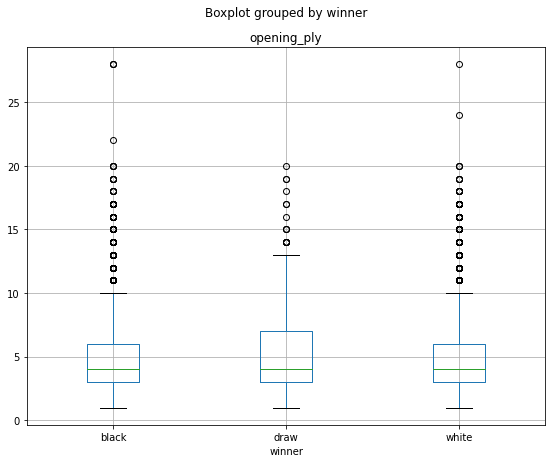

In [78]:
df.boxplot(by = 'winner', column = ['opening_ply'])
plt.show()

In [79]:
X = df[['opening_ply']]
y = df[['winner']]

score, con_mat = log_reg(X, y)

print('The logistic regression score for the opening_ply feature is:', score)

The logistic regression score for the opening_ply feature is: 0.5024417468954933


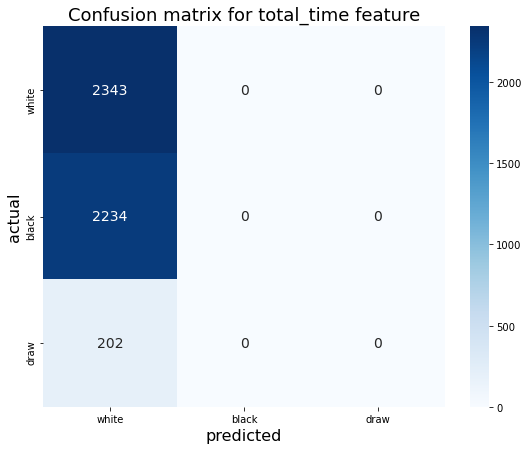

In [80]:
sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["white", "black", "draw"], yticklabels = ["white", "black", "draw"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for total_time feature', fontsize=18)
plt.show()

In [81]:
print('The p value for the opening_ply feature is:', f_classif(X, y.values.ravel())[1][0])

The p value for the opening_ply feature is: 0.00026033229882018946


This feature looks very similar to all the time related features, but with an even higher p value, so using similar arguements as before I would argue this feature is not worth using in modelling. Also, this feature simply indicates the number of turns of the opening move, which is information that would be contained in the `opening_name` feature anyways.

## Multivariate Analysis

This section is just for the `time_allotted` and `increment` features. Basically, since it wasn't clear if they were statistically significant, perhaps they may be together since these features do 'go-together' so to speak. 

In [82]:
X = df[['time_allotted', 'increment']]
y = df[['winner']]

score, con_mat = log_reg(X, y)

print('The logistic regression score for the time_allotted and increment features is:', score)

The logistic regression score for the time_allotted and increment features is: 0.5029300962745918


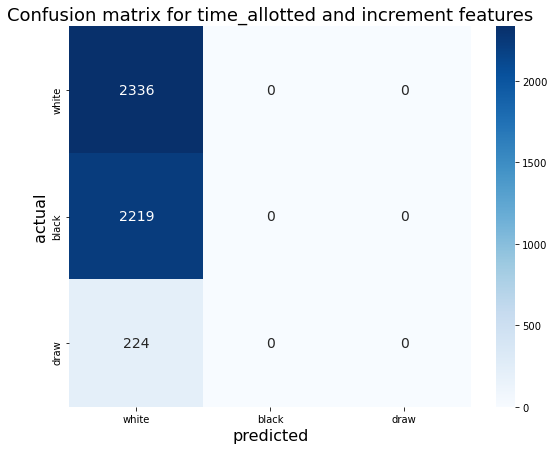

In [83]:
sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["white", "black", "draw"], yticklabels = ["white", "black", "draw"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for time_allotted and increment features', fontsize=18)
plt.show()

In [84]:
print('The p value for the opening_ply feature is:', f_classif(X, y.values.ravel())[1][0])

The p value for the opening_ply feature is: 2.0795943191994896e-06


Alas, similar results occurred, so it remains inconclusive if these features are statistically significant, though based on the confusion matrix and p value alone, it is probably best to leave them out.

## PCA feature importance

Let's do a quick feature importance check with PCA. First we will standardize the numeric columns, and then one-hot encode the categorical vairables. 

In [98]:
numeric_cols = ['turns', 'white_rating', 'black_rating', 'opening_ply', 'time_allotted', 'increment', 'total_time']

standardized = scale(df[numeric_cols])

stand_df = pd.DataFrame(standardized, columns = numeric_cols)

stand_df.head()

,turns,white_rating,black_rating,opening_ply,time_allotted,increment,total_time
0,-1.418858,-0.335500,-1.373962,0.065835,0.071153,-0.227871,-0.177754
1,-1.329272,-0.949261,-1.132944,-0.291536,-0.514602,0.351493,-0.177754
2,0.014518,-0.349292,-0.310038,-0.648908,-0.514602,0.351493,-0.177754
3,-1.657754,-1.197524,-2.024712,-0.291536,-0.221724,-0.372712,-0.177754
4,-0.821618,-0.266538,-0.575158,1.852692,-0.221724,-0.372712,-0.177754


In [99]:
#one-hot encoding like we did at the beginning of the notebook
vic_stat_col = pd.get_dummies(df['victory_status'])

#replacing boolean values with 1's and 0's
rated_col = df.rated.replace({True: 1, False: 0})

In [100]:
#putting the pre-processed dataframes together
pre_proc_df = stand_df.join(rated_col).join(vic_stat_col)

In [101]:
pca = PCA()

pca_df = pca.fit(pre_proc_df)

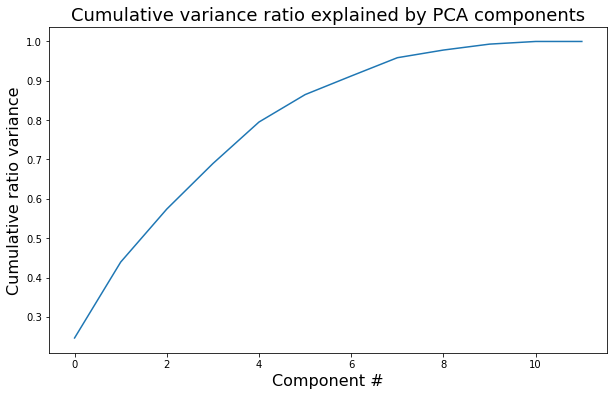

In [89]:
plt.subplots(figsize=(10, 6))
plt.plot(pca_df.explained_variance_ratio_.cumsum())
plt.xlabel('Component #', fontsize=16)
plt.ylabel('Cumulative ratio variance', fontsize=16)
plt.title('Cumulative variance ratio explained by PCA components', fontsize=18);

So it seems like perhaps at least 6 or 7 of these features should be used. This is just to get a quick look at feature importance though. Intuitively the text columns will be the most important, which we didn't include anywhere yet, but we can look at them breifly now. 

## Exploring Text Columns

There are three columns with text data, namely `moves`, `opening_eco`, and `opening_name`. Let's quickly look at them more closely before tokenizing them in the next notebook.

In [104]:
#getting the number of unique values in the moves columns
print('The number of unique values in the moves column is:', df['moves'].unique().shape[0])
print('The number of unique values in the opening_eco column is:', df['opening_eco'].unique().shape[0])
print('The number of unique values in the opening_name column is:', df['opening_name'].unique().shape[0])

The number of unique values in the moves column is: 18920
The number of unique values in the opening_eco column is: 365
The number of unique values in the opening_name column is: 1477


In [105]:
#the opening_eco is a standardized code for openings
print(df['opening_eco'][0]) #take a look at the first value

D10


In [106]:
text_df = df[['moves', 'opening_eco', 'opening_name']]

#lets just hone in one D10 for now to see what the other columns look like
D10 = text_df[text_df['opening_eco'] == df['opening_eco'][0]]

In [107]:
D10['opening_name'].unique()

array(['Slav Defense: Exchange Variation', 'Slav Defense',
       'Slav Defense #2', 'Slav Defense: Slav Gambit |  Alekhine Attack',
       'Slav Defense #3', 'Slav Defense: Winawer Countergambit'],
      dtype=object)

In [109]:
print('The number of rows where the opening_eco is D10 is:', D10['moves'].unique().shape[0])

The number of rows where the opening_eco is D10 is: 106


So it looks like `opening_eco` is a code that is a sort of umbrella term for certain types of openings. In this case D10 represents all Slav Defence openings. This is good to know and makes sense. It could indicate that one of these columns is rundundant or may possibly cause overfitting, since the `opening_name` column is essentially a more detailed or more informative column than `opening_eco`. Thus, if we run into overfitting later on we could experiment with dropping one of these columns.

That being said, the `opening_eco` and `opening_name` have too many unique values to make them categorical, so we will keep them as text columns to be tokenized. This means we won't know much more about these columns until later notebooks. The `opening_eco` could potentially be encoded as categorical with methods other than one-hot encoding though, but with 365 unqiue values it may still not be worth trying. 

Now, let's move on to the `moves` column. Since the `total_time` column was quite faulty, we can actually get another estimate of how long games were, by looking at how many moves were made in each game. Let's try this and make a box plot.

In [115]:
#getting the len of the games by moves completed
df['len_of_moves'] = text_df['moves'].str.split().str.len()

In [117]:
#summary stats
df['len_of_moves'].describe()

count    19113.000000
mean        60.513839
std         33.488264
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: len_of_moves, dtype: float64

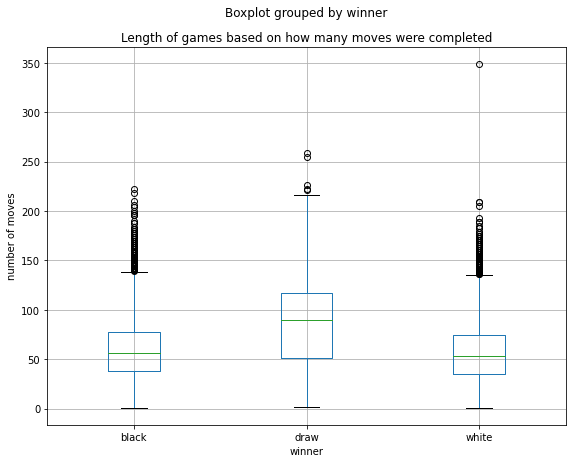

In [119]:
df.boxplot(column='len_of_moves', by='winner')
plt.title('Length of games based on how many moves were completed')
plt.ylabel('number of moves')
plt.show()

This may give a more accurate representation of how long games tended to go, since the `total_time` feature had too many zero values, and regardless looks much better than the box plot of the `total_time` feature since it doesn't have a bunch of zero values dragging the plot to the bottom. In fact, this plot does make more sense when you think about it, since the draws have the longer games, which you would expect intuitively (you could still see this in the `total_time` column, but not as well). Also, when either player wins, there are still lots of outliers, but not more for white or black. This feature seemingly would be useful in predicting draws, and differentiating draws from victories. 

So, let's use this feature instead of the `total_time` feature. 

In [121]:
new_df = df.drop(columns='total_time', axis=1)
new_df.columns

Index(['id', 'rated', 'turns', 'victory_status', 'winner', 'white_id',
       'white_rating', 'black_id', 'black_rating', 'moves', 'opening_eco',
       'opening_name', 'opening_ply', 'time_allotted', 'increment',
       'len_of_moves'],
      dtype='object')

In [122]:
new_df.to_pickle('EDA_df.pkl')

## Summary

Going through all the features, we saw how they behaved in relation to the target variable, which is the winner feature. We also did some statistical tests to get a sense of feature importance, and combined with intuition, we now have an idea of which features to use for predictive modelling.

1. **id** - id's don't make sense to use for modelling.
2. **rated** - no statistically significant, given high p value
3. **total_time** - not statistically significant unless you remove all rows with only 0 values, but this may be a special case since too many rows will be removed in that case. In any case, it was dropped and replaced with a len_of_moves column
4. **time_allotted** - inconclusive if statistically significant, but if we agree that the victory_status feature has the necessary information from this feature anyways, then it is reasonable to drop it
5. **increment** - same situation as the time_allotted feature
6. **victory_status** - statistically significant, though it must be one-hot encoded
7. **winner** - target variable
8. **turns** - statistically significant (though note that the logestic regression model still favoured white in it's predictions)
9. **white_id** - id's don't make sense to use for modelling.
10. **white_rating** - statistically significant (though note that the logistic regression only predicted white here), and not redundant to the black_rating feature
11. **black_id** - id's don't make sense to use for modelling.
12. **black_rating** - statistically significant, and not redundant to the white_rating feature. Note that this feature had a more balanced prediction than the white_rating feature, in that it did not only predict white, nor did it favour it as much as other features. Thus, if need be, despite p values, the white_rating could be dropped and black_rating kept.
13. **moves** - long formatted strings, so we will pre-process and analyze these in the next notebook 
14. **opening_eco** - long formatted strings, so we will pre-process and analyze these in the next notebook
15. **opening_name** - long formatted strings, so we will pre-process and analyze these in the next notebook
16. **opening_ply** - not statistically significant enough, since logistic regression predicted only white, and p value determined to be too high

Also, with a quick PCA feature importance check, it seems like around 7 of the features give the most information. This is not including the text columns though, which are also likely the most important columns.

Moreover, with regards to the text columns, the `opening_eco` feature seems to contain umbrella values that describe a collection of opening moves in the `opening_name` column. This means that the `opening_name` column may be a more informative version of the `opening_eco` column. This may be useful information if overfitting is an issue later on. 

Finally, with the `moves` column, the `len_of_moves` column was obtained and used to replace the `total_time` column. This column counts the total number of moves completed in a game and thus give a sense of how long it was, thus removing the need to deal with the `total_time` column and all its zero values. The moves column will still have value of course, and perhaps since it is included may make this new column redundant - just something to note.